In [1]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load and process the data

In [3]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
y = pd.Series(data=df['Passengers'].values, index=df['Month'])
y.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

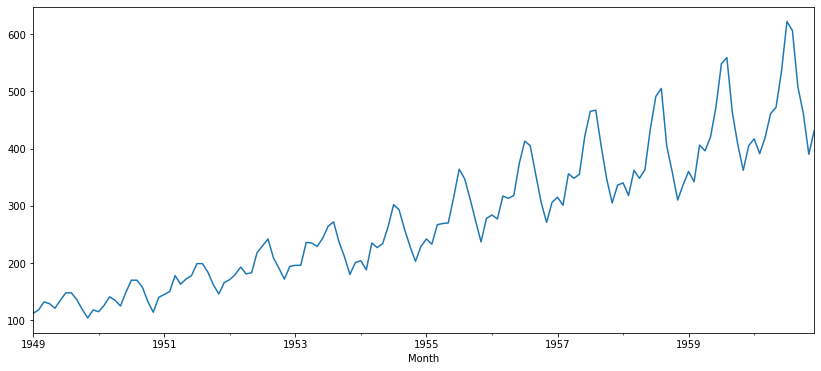

In [5]:
y.plot(figsize=(14, 6))
plt.show()

In [6]:
data = y.values.reshape(y.size,1)

# LSTM Forecast Model

### LSTM Data Preparation

In [7]:
'MixMaxScaler'
scaler = MinMaxScaler(feature_range=(0, 1))
data   = scaler.fit_transform(data)

In [8]:
train_size  = int(len(data) * 0.8)
test_size   = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('data train size :',train.shape[0])
print('data test size  :',test.shape[0])

data train size : 115
data test size  : 29


In [9]:
'function to reshape data according to the number of lags'

def reshape_data (data, look_back,time_steps):
    
    sub_seqs = int(look_back/time_steps)
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    dataX = np.reshape(dataX,(dataX.shape[0],sub_seqs,time_steps,np.size(data,1)))
    return dataX, dataY

In [10]:
look_back = 2
time_steps = 1

trainX, trainY = reshape_data(train, look_back,time_steps)
testX, testY = reshape_data(test, look_back,time_steps)
print('train shape :',trainX.shape)
print('test shape  :',testX.shape)

train shape : (112, 2, 1, 1)
test shape  : (26, 2, 1, 1)


## Define and Fit  the Model

In [11]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, time_steps, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), verbose=0)

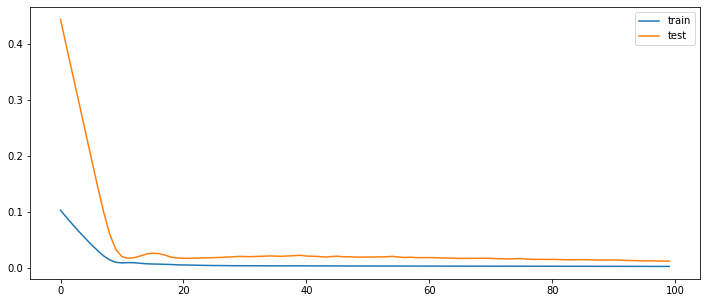

In [12]:
'plot history'
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test the performances

In [13]:
'make predictions'
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [14]:
'invert predictions'
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
'calculate root mean squared error' 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 28.76 RMSE
Test Score: 57.63 RMSE


In [16]:
'shift train predictions for plotting'
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

'shift test predictions for plotting'
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

In [17]:
'Make as pandas series to plot'
data_series = pd.Series(scaler.inverse_transform(data).ravel(), index=df['Month'])
trainPredict_series = pd.Series(trainPredictPlot.ravel(), index=df['Month'])
testPredict_series  = pd.Series(testPredictPlot.ravel(), index=df['Month'])

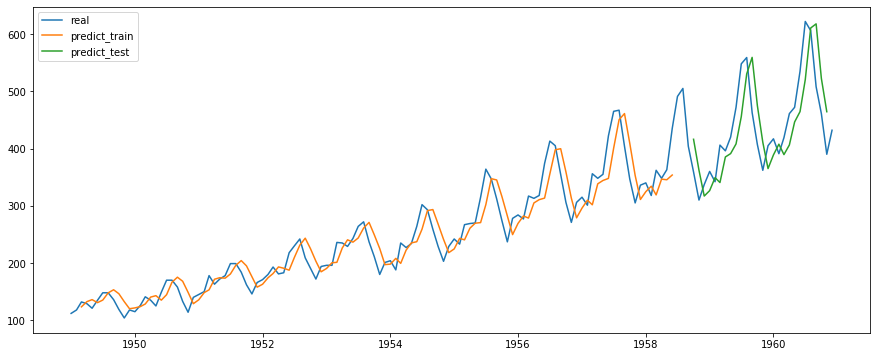

In [18]:
'plot baseline and predictions'
plt.figure(figsize=(15,6))
plt.plot(data_series,label = 'real')
plt.plot(trainPredict_series,label = 'predict_train')
plt.plot(testPredict_series,label = 'predict_test')
plt.legend()
plt.show()

In [19]:
'Predict all the data'
dataX, dataY = reshape_data(data, look_back,time_steps)
dataPredict = model.predict(dataX)

dataPredict = scaler.inverse_transform(dataPredict)
dataY = scaler.inverse_transform([dataY])

dataPredictPlot = np.empty_like(data)
dataPredictPlot[:, :] = np.nan
dataPredictPlot[look_back:len(dataPredict)+look_back, :] = dataPredict

dataPredict_series = pd.Series(dataPredictPlot.ravel(), index=df['Month'])

## STL Decomposing 

In [20]:
predicted = dataPredict_series.dropna()

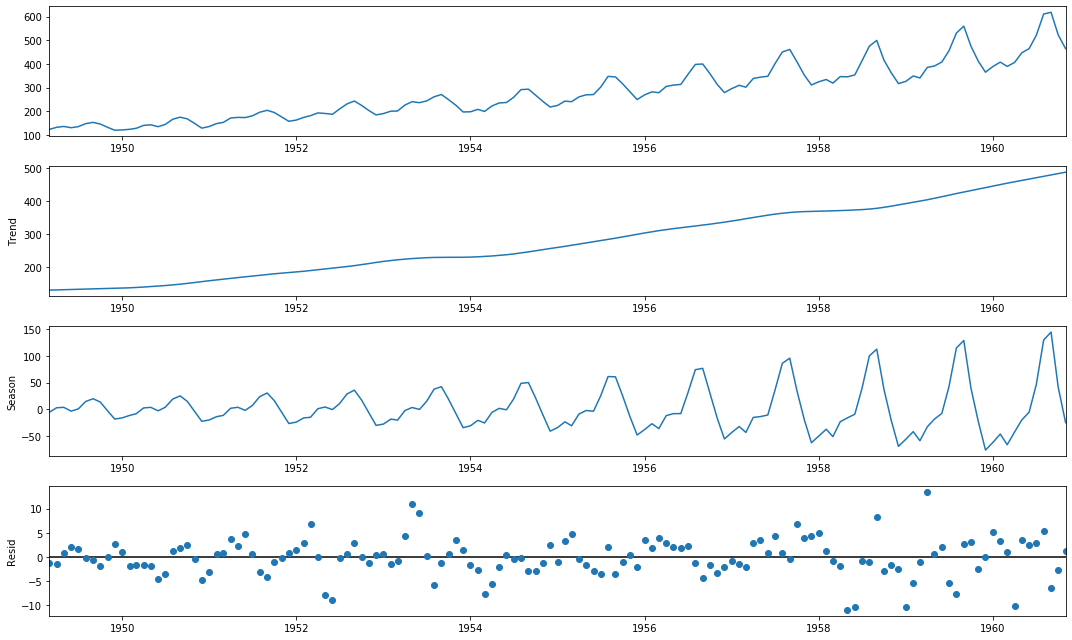

In [21]:
rcParams['figure.figsize'] = 15, 9
stl = STL(predicted).fit()
fig = stl.plot()
plt.show()

## Seasonal plot 

In [22]:
df = predicted.to_frame().reset_index()
df = df.rename(columns= {0: 'Passengers'})
df.head()

,Month,Passengers
0,1949-03-01,123.465477
1,1949-04-01,132.499329
2,1949-05-01,136.050613
3,1949-06-01,130.781265
4,1949-07-01,135.259811


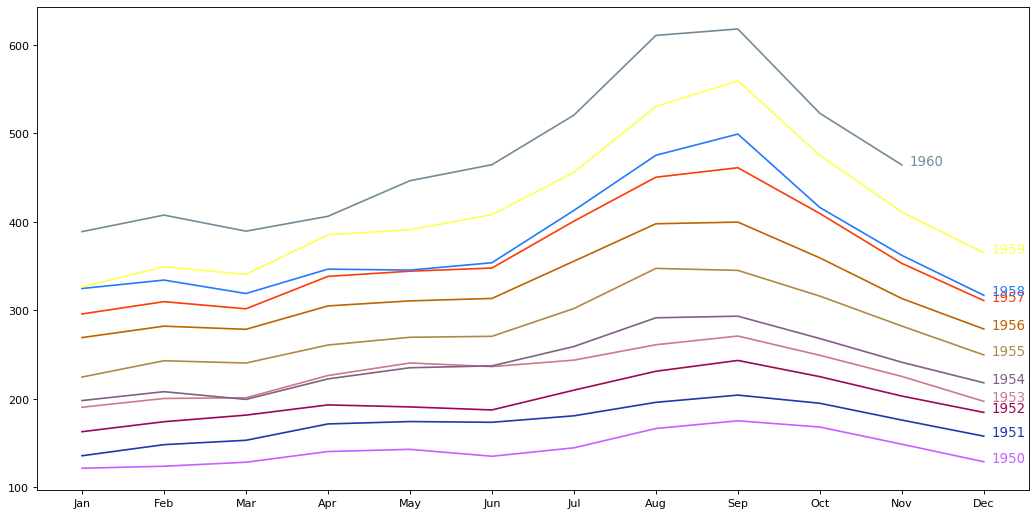

In [23]:
# Prepare data

df['year'] = [d.year for d in df.Month]
df['month'] = [d.strftime('%b') for d in df.Month]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Passengers', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'Passengers'][-1:].values[0], y, 
                 fontsize=12, color=mycolors[i])

## Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

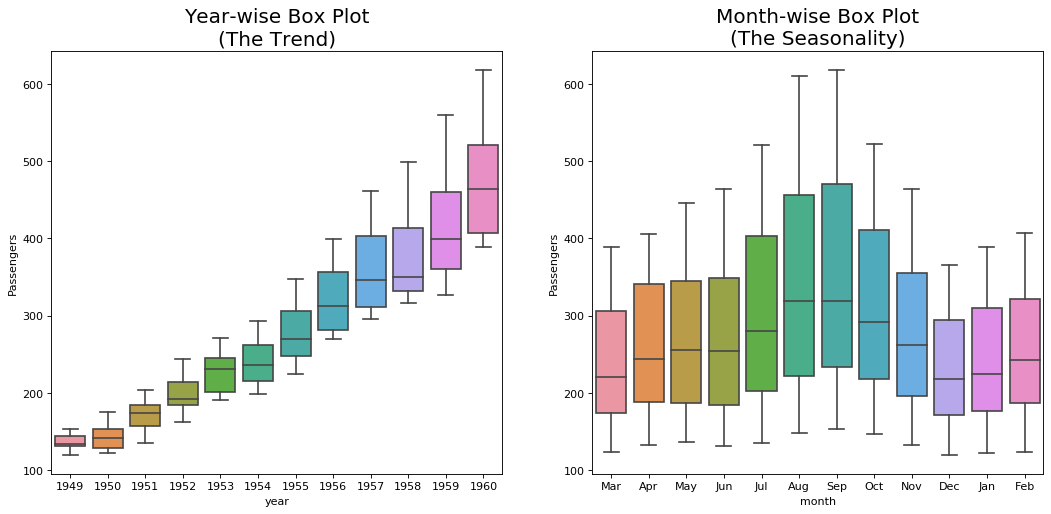

In [24]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(16,7), dpi= 80)
sns.boxplot(x='year', y='Passengers', data=df, ax=axes[0])
sns.boxplot(x='month', y='Passengers', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# SARIMA Model

## Grid search the p, d, q parameters

In [25]:
'Define the p, d and q parameters to take any value between 0 and 3'
p = d = q = range(0, 3)

'Generate all different combinations of p, q and q triplets'
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [26]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sm.tsa.statespace.SARIMAX(predicted,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
            
        print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

        if results.aic < best_result[2]:
            best_result = [param, param_seasonal, results.aic]
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 1999.1298032339455
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 1705.5995475587015
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 1461.4723821109496
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 1278.8726495345993
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 1119.4777970195346
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 977.5591319589794
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 1056.9841636337605
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 905.0731553529683
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 789.9431040845899
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 1067.9417187130452
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 1054.6860778159871
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 963.788364195191
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 1065.2211768593318
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 990.3363221421715
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 861.692843631488
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 934.622075510403
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 903.4418290336705
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 791.

ARIMA(0, 1, 2) x (1, 1, 1, 12) - AIC: 833.7234597547465
ARIMA(0, 1, 2) x (1, 1, 2, 12) - AIC: 747.9755396976434
ARIMA(0, 1, 2) x (1, 2, 0, 12) - AIC: 785.3695962688748
ARIMA(0, 1, 2) x (1, 2, 1, 12) - AIC: 748.7575169352713
ARIMA(0, 1, 2) x (1, 2, 2, 12) - AIC: 662.8304716635569
ARIMA(0, 1, 2) x (2, 0, 0, 12) - AIC: 832.9202466704614
ARIMA(0, 1, 2) x (2, 0, 1, 12) - AIC: 834.8538078814597
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC: 814.2987465940289
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC: 770.5379013750296
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC: 772.531833876066
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC: 749.2158432139582
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC: 698.1575376725109
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC: 687.1271053446818
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC: 664.6476811909881
ARIMA(0, 2, 0) x (0, 0, 0, 12) - AIC: 1330.645166572484
ARIMA(0, 2, 0) x (0, 0, 1, 12) - AIC: 1134.398860003662
ARIMA(0, 2, 0) x (0, 0, 2, 12) - AIC: 990.6881272802705
ARIMA(0, 2, 0) x (0, 1, 0, 12) - AIC: 995.2584968

ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC: 685.489384786573
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC: 678.7479316175217
ARIMA(1, 0, 2) x (0, 0, 0, 12) - AIC: 1270.3187129152125
ARIMA(1, 0, 2) x (0, 0, 1, 12) - AIC: 1088.9955975255943
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC: 948.000016191856
ARIMA(1, 0, 2) x (0, 1, 0, 12) - AIC: 917.9776545339575
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC: 840.3731951847769
ARIMA(1, 0, 2) x (0, 1, 2, 12) - AIC: 760.861193603574
ARIMA(1, 0, 2) x (0, 2, 0, 12) - AIC: 889.6186390262286
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC: 754.3327691307037
ARIMA(1, 0, 2) x (0, 2, 2, 12) - AIC: 666.1756558172002
ARIMA(1, 0, 2) x (1, 0, 0, 12) - AIC: 912.2455748634302
ARIMA(1, 0, 2) x (1, 0, 1, 12) - AIC: 894.2346692708095
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC: 820.1133989998403
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC: 853.6029018347839
ARIMA(1, 0, 2) x (1, 1, 1, 12) - AIC: 842.5074482688507
ARIMA(1, 0, 2) x (1, 1, 2, 12) - AIC: 752.3150207345335
ARIMA(1, 0, 2) x (1, 2, 0, 12) - AIC: 783.4824752

ARIMA(1, 2, 1) x (1, 0, 1, 12) - AIC: 900.51610087979
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC: 825.6090192032157
ARIMA(1, 2, 1) x (1, 1, 0, 12) - AIC: 843.1745973382281
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC: 839.2670439837916
ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC: 757.3461264698415
ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC: 777.4998272308268
ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC: 758.4272952353439
ARIMA(1, 2, 1) x (1, 2, 2, 12) - AIC: 668.3470962389297
ARIMA(1, 2, 1) x (2, 0, 0, 12) - AIC: 828.384602794025
ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC: 830.2347590851678
ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC: 823.8357263530213
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC: 763.2002579744956
ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC: 765.0980621480205
ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC: 759.3463034255401
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC: 688.3486465187158
ARIMA(1, 2, 1) x (2, 2, 1, 12) - AIC: 678.3074142347508
ARIMA(1, 2, 1) x (2, 2, 2, 12) - AIC: 670.2966345299623
ARIMA(1, 2, 2) x (0, 0, 0, 12) - AIC: 1256.19688158

ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC: 759.424280787428
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC: 757.2064859488072
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC: 680.9435108336096
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC: 671.0517860410708
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC: 671.6091848713277
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC: 1258.9550171884935
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC: 1070.8000153771932
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC: 933.3034316115827
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC: 912.4806048918083
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC: 834.7704380245036
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC: 757.1113644895759
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC: 893.9942537162369
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC: 757.6335297020902
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC: 669.021862988384
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC: 903.5814034824691
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC: 899.2659156524767
ARIMA(2, 1, 1) x (1, 0, 2, 12) - AIC: 825.0485217514613
ARIMA(2, 1, 1) x (1, 1, 0, 12) - AIC: 834.770519

## Train the model

In [146]:
mod = sm.tsa.statespace.SARIMAX(predicted,
                                order=(1,1,1),
                                seasonal_order=(0,1,0, best_result[1][3]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  141
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -453.496
Date:                             Fri, 15 May 2020   AIC                            912.992
Time:                                     19:58:46   BIC                            921.501
Sample:                                 03-01-1949   HQIC                           916.449
                                      - 11-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8447      0.082     10.326      0.000       0.684       1.005
ma.L1         -0.9811      

## Explain the params (P,D,Q) S(p,d,q)

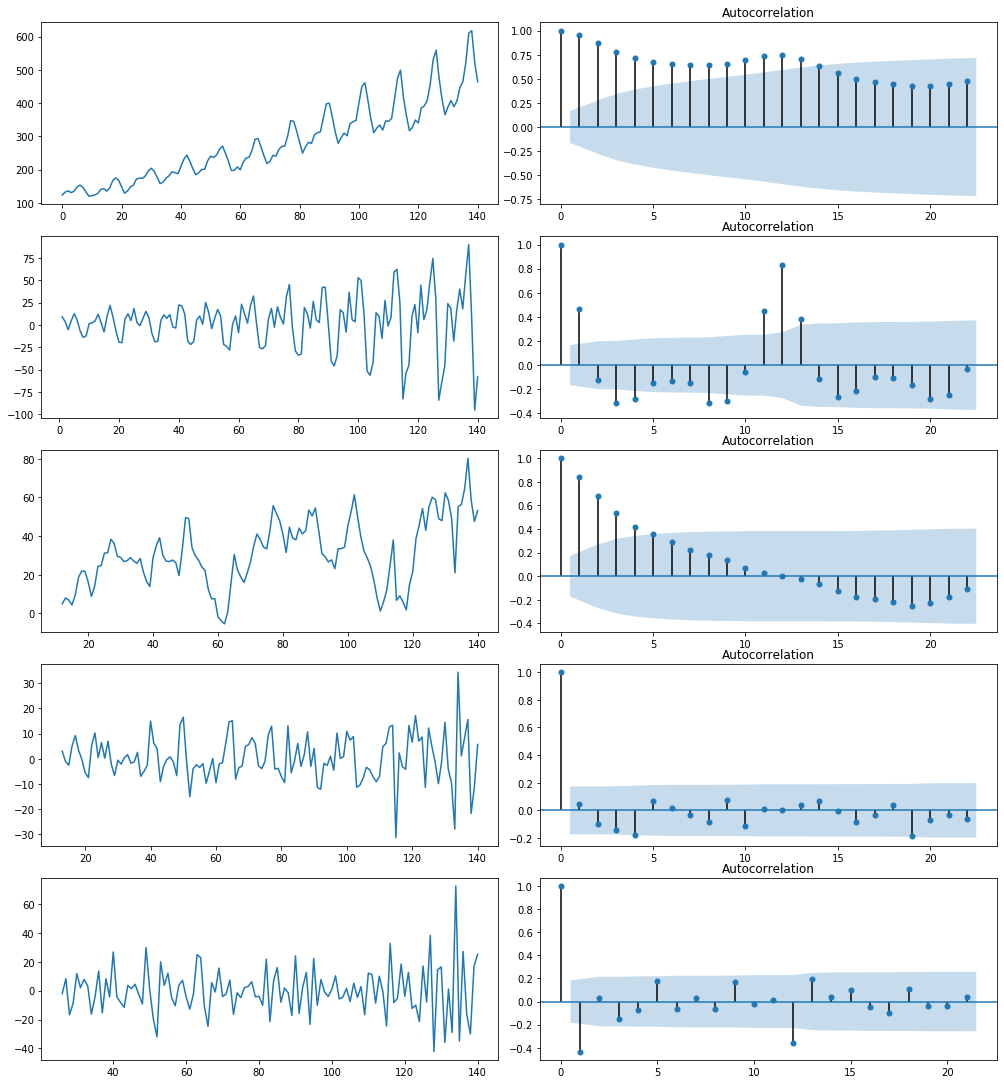

In [139]:
'parameter D : the order of differencing'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(5, 2,figsize=(14,15))
fig.tight_layout()
axes[0, 0].plot(df.Passengers); axes[0, 0].set_title('')
plot_acf(df.Passengers, ax=axes[0, 1])


axes[1, 0].plot(df.Passengers.diff()); axes[1, 0].set_title('')
plot_acf(df.Passengers.diff().dropna(), ax=axes[1, 1])


axes[2, 0].plot(df.Passengers.diff(12)); axes[2, 0].set_title('')
plot_acf(df.Passengers.diff(12).dropna(), ax=axes[2, 1])

axes[3, 0].plot(df.Passengers.diff(12).diff()); axes[3, 0].set_title('')
plot_acf(df.Passengers.diff(12).diff().dropna(), ax=axes[3, 1])


axes[4, 0].plot(df.Passengers.diff(12).diff().diff(12).diff()); axes[4, 0].set_title('')
plot_acf(df.Passengers.diff(12).diff().diff(12).diff().dropna(), ax=axes[4, 1])

plt.show()


In [103]:
'Adfuller test' 
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Passengers.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Passengers.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Passengers.diff(12).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Passengers.diff(12).diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Passengers.diff(12).diff().diff(12).diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')


ADF Statistic: 1.441906
p-value: 0.997296
------------------------
ADF Statistic: -2.811962
p-value: 0.056585
------------------------
ADF Statistic: -3.151271
p-value: 0.022984
------------------------
ADF Statistic: -7.453048
p-value: 0.000000
------------------------
ADF Statistic: -4.376296
p-value: 0.000327
------------------------


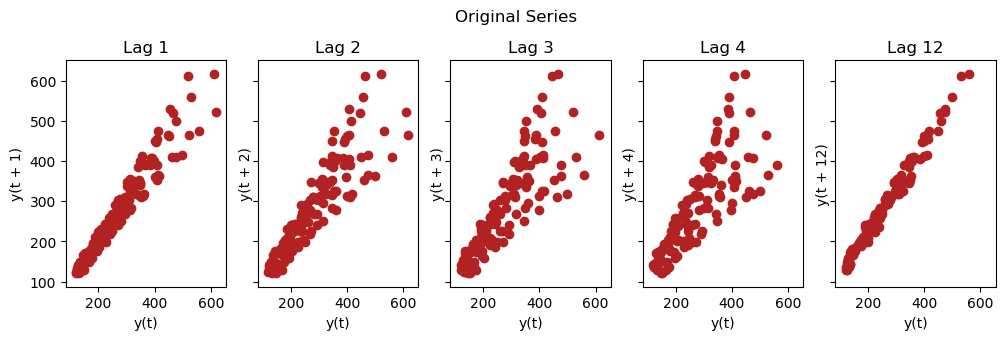

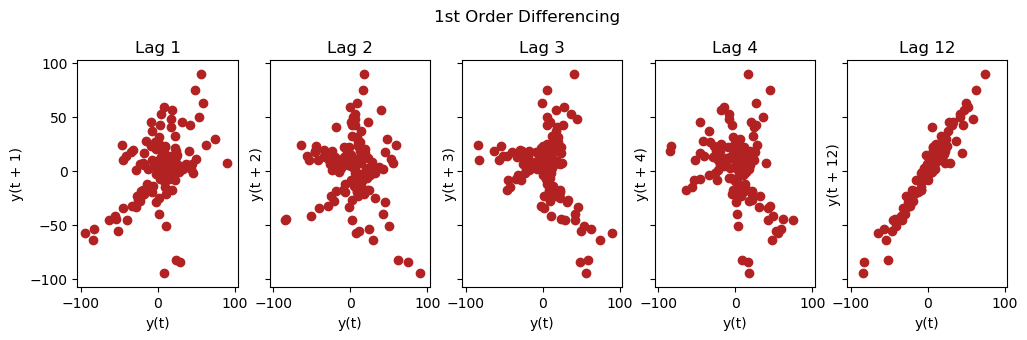

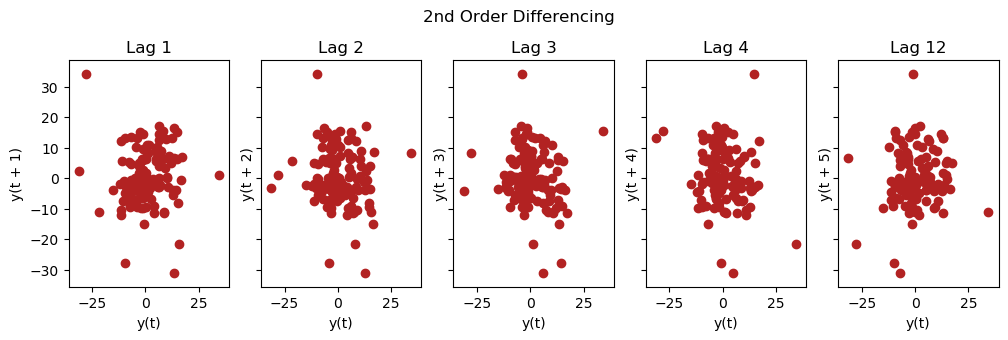

In [99]:
'Plot the lags'
from pandas.plotting import lag_plot

fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 :
        lag_plot(df.Passengers, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers, lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('Original Series', y=1.05)  
    
fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff().dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff().dropna(), lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('1st Order Differencing', y=1.05)  
    
fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff(12).diff().dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff(12).diff().dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('2nd Order Differencing', y=1.05)

plt.show()

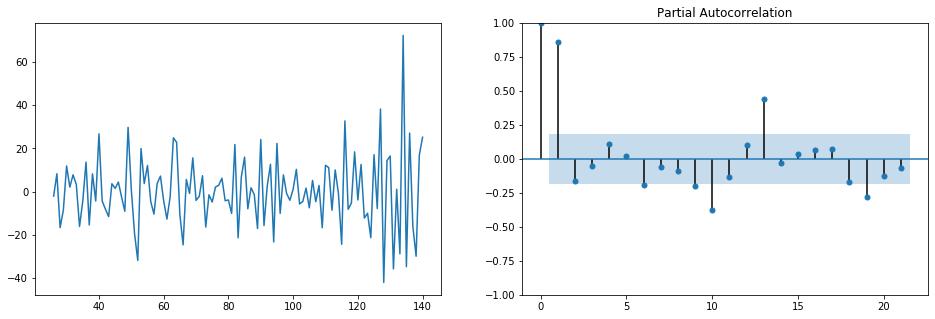

In [137]:
'P : order of AR term & Q : order of MA term'

fig, axes = plt.subplots(1, 2, figsize=(16,5), sharex=False)
axes[0].plot(df.Passengers.diff(12).diff(12).diff().diff()); axes[0].set_title('')
axes[1].set(ylim=(-1,1))
plot_pacf(df.Passengers.diff(12).diff(12).dropna(), ax=axes[1])

plt.show()

## Plot model diagnostics

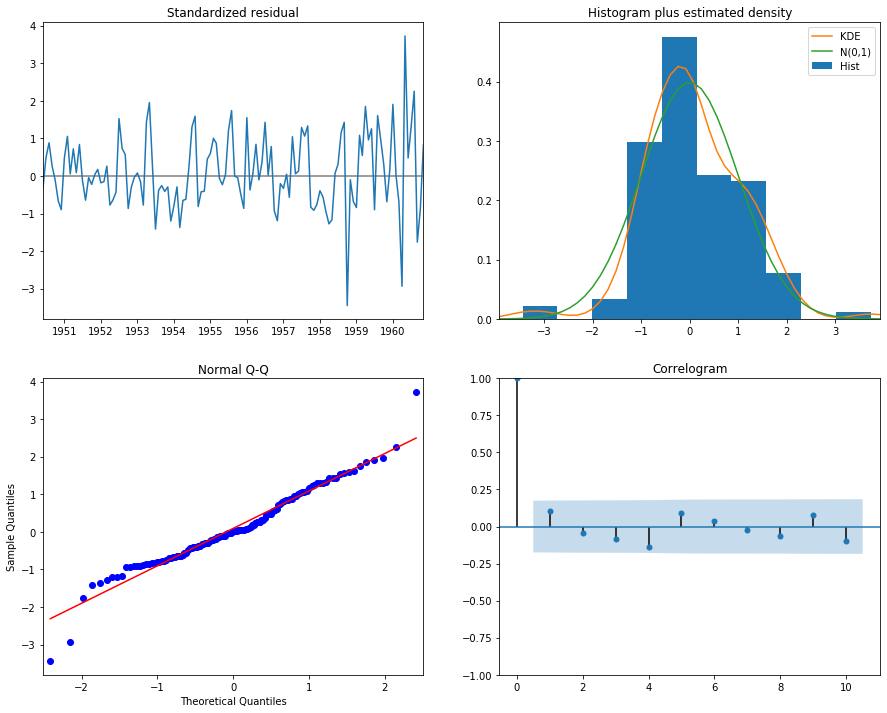

In [147]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [148]:
'make predictions'
pred = results.get_prediction(start=pd.to_datetime('1949-03-01'), dynamic=False,full_results=True)
pred_ci = pred.conf_int()

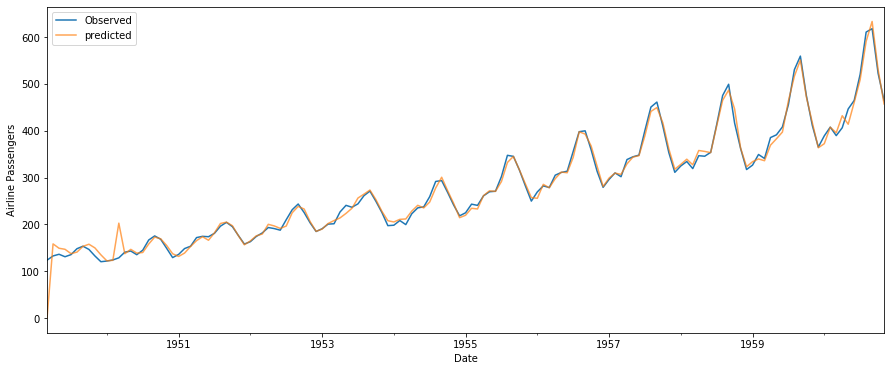

In [149]:
ax = predicted.plot(label='Observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [151]:
trainScore = math.sqrt(mean_squared_error(predicted, pred.predicted_mean))
print('Score: %.2f RMSE' % (trainScore))

Score: 15.13 RMSE
